# Stock Price Prediction - LSTM
---
*@author: Stefan Su*  
*@date: 2023-04-28*  
*@Lisence: MIT Lisence*

## 1. Retrieve Data

> Use `pandas_datareader` to retrieve historical and present stock price by ticker and time range. Here, I choose "GOOGL" as an example, but in the real data product, customer can choose whatever valid stock ticker they want to do prediction.

(Reference [pandas_datareader link](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#stooq-index-data))

#### 1.1 Import required libraries

In [39]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#### 1.2 Set start time and end time as parameters to retrieve data.

In [2]:
start = datetime.date(2000, 1, 1)
end = datetime.date.today()
print(start, end)

2000-01-01 2023-04-28


#### 1.3 Get origianl real-time data from `DataReader`.

In [3]:
ticker = 'GOOGL'
df = web.DataReader(ticker, 'stooq', start, end)
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-04-27,104.45000,108.3700,103.54000,107.59000,50089187.0
2023-04-26,104.92000,106.3500,102.63000,103.71000,53347560.0
2023-04-25,105.82500,106.6900,103.84000,103.85000,46664104.0
2023-04-24,105.49000,106.6300,104.70000,105.97000,23542829.0
2023-04-21,105.47000,106.0000,104.78000,105.41000,25800082.0
...,...,...,...,...,...
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0


#### 1.4 sort the date by ascending



In [4]:
df.dropna(inplace=True)
df.sort_index(inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.50000,2.6015,2.39900,2.50850,894076000.0
2004-08-20,2.52525,2.7270,2.51250,2.70775,457144000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
...,...,...,...,...,...
2023-04-21,105.47000,106.0000,104.78000,105.41000,25800082.0
2023-04-24,105.49000,106.6300,104.70000,105.97000,23542829.0
2023-04-25,105.82500,106.6900,103.84000,103.85000,46664104.0


#### 1.5 Create `label` column as prediction value. We want to know the price/trend of the stock 10 days later.

* `pre_days`: prediction days

In [5]:
pre_days = 10
df['label'] = df['Close'].shift(-pre_days)
df

,Open,High,Low,Close,Volume,label
Date,,,,,,
2004-08-19,2.50000,2.6015,2.39900,2.50850,894076000.0,2.53775
2004-08-20,2.52525,2.7270,2.51250,2.70775,457144000.0,2.50025
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0,2.53950
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0,2.55750
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0,2.55775
...,...,...,...,...,...,...
2023-04-21,105.47000,106.0000,104.78000,105.41000,25800082.0,NaN
2023-04-24,105.49000,106.6300,104.70000,105.97000,23542829.0,NaN
2023-04-25,105.82500,106.6900,103.84000,103.85000,46664104.0,NaN


## 2. Data Preprocessing


#### 2.1 Standardize the data

> Use `StandardScaler` to complete data standardization.

In [6]:
scaler = StandardScaler()
scale_X = scaler.fit_transform(df.iloc[:, :-1])
print(scale_X)

[[-1.02020079 -1.01728517 -1.0229223  -1.0198426   5.09758988]
 [-1.01949078 -1.01379531 -1.01969465 -1.01424127  2.20909426]
 [-1.01264371 -1.01073647 -1.01361617 -1.01347522  1.60316942]
 ...
 [ 1.88523364  1.87717209  1.86179288  1.82907598 -0.50453024]
 [ 1.85978561  1.86771749  1.82738366  1.82514029 -0.46034686]
 [ 1.8465695   1.92388895  1.85326166  1.9342151  -0.48188751]]


#### 2.2 Set train & test data

* `mem_his_days`: memory of history days
* `deq`: a first in first out data structure, which make sure only remember and store the length of `mem_his_days` stock price data.
* `X`: train set, which means `mem_his_days` days of stock price data in each element and excludes last ten records. (refer to see `pre_days`)
* `X_lately`: last ten records.
* `y`: test data, which names 'label' in dataframe.



In [7]:
mem_his_days = 5
deq = deque(maxlen=mem_his_days)

X = []
for i in scale_X:
    deq.append(list(i))
    if len(deq) == mem_his_days:
        X.append(list(deq))

X_lately = X[-pre_days :]
X = np.array(X[: -pre_days])

y = np.array(df['label'].values[mem_his_days - 1: -pre_days])

In [8]:
print(X.shape)
print(y.shape)

(4690, 5, 5)
(4690,)


#### 2.3 Train Test set split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## 3. Generate and Train LSTM Nerual Network

#### 3.1 Add LSTM layers
Reference [LSTM link](https://keras.io/api/layers/recurrent_layers/lstm/)
1. The first layer should have `return_sequences` and define the `input_shape`
2. Repeat add LSTM and Dropout .1 percent data to generate the second and third layers. Remember to remove `input_shape` and `return_sequences` parameters in the last layer since it is defined at the layers before.
3. Add a fully connected layer, and an output layer.
4. Compile the model and use 'adam' as optimizer, use [keras MSE](https://keras.io/api/losses/regression_losses/#meansquarederror-class) as loss function, [keras MAPE](https://keras.io/api/metrics/regression_metrics/#meanabsolutepercentageerror-class) as metrics.

In [10]:
model = Sequential()

# The first layer of Recurrent Neural Network shoule have return_sequences and define input shape
model.add(LSTM(10, input_shape=X.shape[1: ], activation='relu', return_sequences=True))

# To avoid overfitting, use Dropout to remove .1 data
model.add(Dropout(0.1))

# Repeat to generate second and third layers
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(10, activation='relu'))
model.add(Dropout(0.1))

# Generate Fully Connected layers
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

#### 3.2 Train LSTM model

> Note: The parameters of the model are not modified and polished. And it does not mean the model is perfect and we can find that the model become overfitted during the training process.

In [11]:
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
132/132 [==============================] - 10s 15ms/step - loss: 2171.0476 - mape: 87.7493 - val_loss: 275.9417 - val_mape: 46.0735
Epoch 2/50
132/132 [==============================] - 2s 12ms/step - loss: 272.8245 - mape: 32.8086 - val_loss: 41.1079 - val_mape: 17.9358
Epoch 3/50
132/132 [==============================] - 2s 12ms/step - loss: 204.3717 - mape: 28.2007 - val_loss: 55.3681 - val_mape: 17.6427
Epoch 4/50
132/132 [==============================] - 2s 16ms/step - loss: 169.5437 - mape: 26.9752 - val_loss: 49.8854 - val_mape: 16.8374
Epoch 5/50
132/132 [==============================] - 2s 13ms/step - loss: 155.1074 - mape: 25.1210 - val_loss: 64.6596 - val_mape: 16.1746
Epoch 6/50
132/132 [==============================] - 1s 10ms/step - loss: 160.4996 - mape: 25.1097 - val_loss: 39.1356 - val_mape: 14.5679
Epoch 7/50
132/132 [==============================] - 1s 10ms/step - loss: 131.6337 - mape: 23.5786 - val_loss: 84.7723 - val_mape: 17.2291
Epoch 8/50
132/13

**Based on the results above, we notice the model should be optimized to find the best set of parameters which can provide a better prediction output. But before that, we should encapsulate data process part into one function.**

## 4. Encapsulate data process function

Differenct `mem_his_days`, `pre_days` and `df` will influence train result.

In [12]:
def stock_price_LSTM_data_processing(df: pd.DataFrame, mem_his_days: list, pre_days: list):
    df.dropna(inplace=True)
    df.sort_index(inplace=True)

    df['label'] = df['Close'].shift(-pre_days)

    scaler = StandardScaler()
    scale_X = scaler.fit_transform(df.iloc[:, :-1])

    deq = deque(maxlen=mem_his_days)

    X = []
    for i in scale_X:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days :]
    X = np.array(X[: -pre_days])

    y = np.array(df['label'].values[mem_his_days - 1: -pre_days])

    return X, y, X_lately

Try to call the function and pass `df=df`, `mem_his_days=5`, `pre_days=10`.

In [13]:
X, y, X_lately = stock_price_LSTM_data_processing(df=df, mem_his_days=5, pre_days=10)
print(X[0])
print(len(X) == len(y), len(X_lately))

[[-1.01893333 -1.01603035 -1.02167181 -1.01859431  5.0928282 ]
 [-1.01822142 -1.01253104 -1.0184355  -1.01297783  2.20632025]
 [-1.0113561  -1.00946391 -1.01234069 -1.0122097   1.60081236]
 [-1.01101072 -1.01077441 -1.01624707 -1.01540201  1.20287471]
 [-1.01543723 -1.01328388 -1.01602609 -1.01460569  0.40155581]]
True 10


## 5. Optimize Model



#### 5.1 Create list of `mem_days`, `lstm_layers`, `dense_layers`, `units`, and iterate them one by one to figure out the best set of parameters.

* `mem_days`: memory days
* `lstm_layers`: number of different LSTM layers
* `dense_layers`: number of different dense layers
* `units`: number of different neurons in each layer

    **NOTE: the algorithm here is brute force. We can optimize it by using grid search in the future if you want.**

In [14]:
# Self-defined
mem_days = [5, 10, 15]
lstm_layers = [1, 2, 3]
dense_layers = [1, 2, 3]
# units = [8, 16, 32]
units = [8, 16]

#### 5.2 Find best model during the iteration

Use `ModelCheckPoint` in Keras `Callbacks API` to find the best model in each training iteration. Reference [keras Callbacks API ModelCheckPoint](https://keras.io/api/callbacks/model_checkpoint/).

**How many epochs should I train my model with?**  
- The right number of epochs depends on the inherent perplexity (or complexity) of your dataset. ***A good rule of thumb is to start with a value that is 3 times the number of columns in your data.*** If you find that the model is still improving after all epochs complete, try again with a higher value. If you find that the model stopped improving way before the final epoch, try again with a lower value as you may be overtraining. If you have only a small number of records in your dataset or are having a large number of records fail validation, you may need to increase the number of epochs significantly to help the neural network learn the structure of the data. (Reference [How many epochs should I train my model with?](https://gretel.ai/gretel-synthetics-faqs/how-many-epochs-should-i-train-my-model-with))

In [51]:
"""
Run the code below if you want to run the train again

import shutil
shutil.rmtree('./models')
"""

"\nRun the code below if you want to run the train again\n\nimport shutil\nshutil.rmtree('./models')\n"

***Note: It takes a really long time to run it more than 2 hours. You can use keyboard to interrupt it and continue to run other cells. It works well even if with an interruption. (Recommand run at least 20 minutes)***

In [17]:
count_1, count_2, count_3, count_4 = 0, 0, 0, 0
for mem_day in mem_days:
    for lstm_layer in lstm_layers:
        for dense_layer in dense_layers:
            for unit in units:
                filepath = f'./models/{ticker}_' + '{val_mape:.2f}_{epoch:02d}_' + f'mem_{mem_day}_lstm_{lstm_layer}_dense_{dense_layer}_unit_{unit}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True
                )
                X, y, X_lately = stock_price_LSTM_data_processing(df=df, mem_his_days=mem_day, pre_days=pre_days)
                X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

                # Train model in each iteration
                model = Sequential()

                for i in range(lstm_layer):
                    # The first layer of Recurrent Neural Network shoule have return_sequences and define input shape
                    model.add(LSTM(unit, input_shape=X.shape[1: ], activation='relu', return_sequences=True))

                    # To avoid overfitting, use Dropout to remove .1 data
                    model.add(Dropout(0.1))

                # Repeat to generate second and third layers
                model.add(LSTM(unit, activation='relu', return_sequences=True))
                model.add(Dropout(0.1))
                model.add(LSTM(unit, activation='relu'))
                model.add(Dropout(0.1))

                for i in range(dense_layer):
                    # Generate Fully Connected layers
                    model.add(Dense(unit, activation='relu'))
                    model.add(Dropout(0.1))

                # Output layer
                model.add(Dense(1))

                # Compile model
                model.compile(optimizer='adam', loss='mse', metrics=['mape'])

                # Train model
                model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test), callbacks=[checkpoint])
                count_1 += 1
                print('count_1', count_1)
            count_2 += 1
            print('count_2', count_2)
        count_3 += 1
        print('count_3', count_3)
    count_4 += 1
    print('count_4', count_4)

Epoch 1/15
131/132 [============================>.] - ETA: 0s - loss: 1146.8660 - mape: 89.4776

132/132 [==============================] - 14s 69ms/step - loss: 1146.5823 - mape: 89.4539 - val_loss: 5664.6973 - val_mape: 52.0496
Epoch 2/15
130/132 [============================>.] - ETA: 0s - loss: 223.9070 - mape: 38.4756

132/132 [==============================] - 7s 56ms/step - loss: 223.0863 - mape: 38.4231 - val_loss: 70.9299 - val_mape: 5.8869
Epoch 3/15
132/132 [==============================] - 2s 12ms/step - loss: 120.4313 - mape: 27.4174 - val_loss: 355.8726 - val_mape: 13.8329
Epoch 4/15
132/132 [==============================] - 2s 15ms/step - loss: 121.3325 - mape: 27.0581 - val_loss: 175.0363 - val_mape: 8.8532
Epoch 5/15
132/132 [==============================] - 2s 13ms/step - loss: 100.4437 - mape: 26.0836 - val_loss: 166.2848 - val_mape: 9.0624
Epoch 6/15
132/132 [==============================] - 1s 10ms/step - loss: 93.2708 - mape: 24.8639 - val_loss: 126.4158 - val_mape: 7.6730
Epoch 7/15
132/132 [==============================] - 1s 10ms/step - loss: 84.1198 - mape: 24.0439 - val_loss: 80.6392 - val_mape: 6.2656
Epoch 8/15
132/132 [==============================] - ETA: 0s - loss: 90.2634 - mape: 24.0263

132/132 [==============================] - 8s 64ms/step - loss: 90.2634 - mape: 24.0263 - val_loss: 62.1215 - val_mape: 5.5357
Epoch 9/15
132/132 [==============================] - 2s 11ms/step - loss: 86.1684 - mape: 24.1234 - val_loss: 70.2400 - val_mape: 5.8838
Epoch 10/15
129/132 [============================>.] - ETA: 0s - loss: 78.1379 - mape: 23.4598

132/132 [==============================] - 8s 60ms/step - loss: 77.3624 - mape: 23.4481 - val_loss: 61.0162 - val_mape: 5.4835
Epoch 11/15
132/132 [==============================] - ETA: 0s - loss: 75.4869 - mape: 22.4641

132/132 [==============================] - 9s 71ms/step - loss: 75.4869 - mape: 22.4641 - val_loss: 60.2124 - val_mape: 5.4587
Epoch 12/15
132/132 [==============================] - 1s 11ms/step - loss: 67.3687 - mape: 22.3962 - val_loss: 269.8875 - val_mape: 12.0903
Epoch 13/15
132/132 [==============================] - 1s 10ms/step - loss: 65.8137 - mape: 22.4918 - val_loss: 139.2440 - val_mape: 8.3284
Epoch 14/15
132/132 [==============================] - 1s 10ms/step - loss: 68.8816 - mape: 22.2217 - val_loss: 78.7418 - val_mape: 6.2298
Epoch 15/15
132/132 [==============================] - 2s 18ms/step - loss: 60.9713 - mape: 21.6595 - val_loss: 220.1416 - val_mape: 10.4922
count_1 1
Epoch 1/15
128/131 [============================>.] - ETA: 0s - loss: 978.3328 - mape: 81.3947 

131/131 [==============================] - 13s 65ms/step - loss: 961.5664 - mape: 80.7120 - val_loss: 12074.3447 - val_mape: 78.4673
Epoch 2/15
129/131 [============================>.] - ETA: 0s - loss: 103.3254 - mape: 30.8895

131/131 [==============================] - 9s 66ms/step - loss: 102.8440 - mape: 30.7935 - val_loss: 272.9099 - val_mape: 10.2702
Epoch 3/15
128/131 [============================>.] - ETA: 0s - loss: 75.6773 - mape: 25.6689

131/131 [==============================] - 8s 63ms/step - loss: 75.7721 - mape: 25.6317 - val_loss: 183.7032 - val_mape: 8.4507
Epoch 4/15
130/131 [============================>.] - ETA: 0s - loss: 67.3503 - mape: 24.0671

131/131 [==============================] - 10s 73ms/step - loss: 67.5584 - mape: 24.0793 - val_loss: 168.3621 - val_mape: 8.0951
Epoch 5/15
131/131 [==============================] - 2s 12ms/step - loss: 67.3278 - mape: 22.9392 - val_loss: 539.9341 - val_mape: 15.5142
Epoch 6/15
128/131 [============================>.] - ETA: 0s - loss: 59.8359 - mape: 21.6341

131/131 [==============================] - 8s 61ms/step - loss: 59.4222 - mape: 21.6974 - val_loss: 119.2245 - val_mape: 7.1241
Epoch 7/15
131/131 [==============================] - 2s 14ms/step - loss: 52.9938 - mape: 20.5045 - val_loss: 269.5659 - val_mape: 10.2941
Epoch 8/15
131/131 [==============================] - 1s 11ms/step - loss: 54.7800 - mape: 20.4380 - val_loss: 283.8654 - val_mape: 11.0988
Epoch 9/15
130/131 [============================>.] - ETA: 0s - loss: 50.0604 - mape: 20.0125

131/131 [==============================] - 8s 64ms/step - loss: 50.4541 - mape: 19.9970 - val_loss: 78.9752 - val_mape: 6.2950
Epoch 10/15
131/131 [==============================] - 3s 19ms/step - loss: 50.3579 - mape: 19.1266 - val_loss: 263.0486 - val_mape: 10.8047
Epoch 11/15
131/131 [==============================] - 2s 12ms/step - loss: 52.1208 - mape: 19.5150 - val_loss: 141.8943 - val_mape: 7.4476
Epoch 12/15
131/131 [==============================] - 1s 11ms/step - loss: 50.8160 - mape: 18.8882 - val_loss: 211.3912 - val_mape: 9.1527
Epoch 13/15
131/131 [==============================] - 1s 11ms/step - loss: 45.0844 - mape: 17.8728 - val_loss: 117.6582 - val_mape: 7.7355
Epoch 14/15
129/131 [============================>.] - ETA: 0s - loss: 47.3702 - mape: 18.5736

131/131 [==============================] - 9s 70ms/step - loss: 47.4626 - mape: 18.5410 - val_loss: 73.6293 - val_mape: 5.7997
Epoch 15/15
131/131 [==============================] - ETA: 0s - loss: 47.2087 - mape: 18.2659

131/131 [==============================] - 7s 54ms/step - loss: 47.2087 - mape: 18.2659 - val_loss: 69.1179 - val_mape: 5.7111
count_1 2
count_2 1
Epoch 1/15
131/131 [==============================] - ETA: 0s - loss: 1203.2112 - mape: 93.1408

131/131 [==============================] - 14s 66ms/step - loss: 1203.2112 - mape: 93.1408 - val_loss: 35763.4062 - val_mape: 144.6911
Epoch 2/15
130/131 [============================>.] - ETA: 0s - loss: 268.0453 - mape: 42.9164

131/131 [==============================] - 8s 64ms/step - loss: 267.4740 - mape: 42.8794 - val_loss: 87.3494 - val_mape: 6.4126
Epoch 3/15
131/131 [==============================] - 1s 10ms/step - loss: 184.0757 - mape: 36.6440 - val_loss: 87.3857 - val_mape: 6.5168
Epoch 4/15
131/131 [==============================] - 1s 10ms/step - loss: 171.6726 - mape: 33.8885 - val_loss: 89.7103 - val_mape: 6.6650
Epoch 5/15
131/131 [==============================] - 1s 10ms/step - loss: 168.2249 - mape: 34.5292 - val_loss: 271.1856 - val_mape: 12.3057
Epoch 6/15
131/131 [==============================] - 1s 11ms/step - loss: 153.1192 - mape: 32.7059 - val_loss: 116.5527 - val_mape: 7.6907
Epoch 7/15
131/131 [==============================] - 2s 15ms/step - loss: 141.1309 - mape: 32.2373 - val_loss: 89.6822 - val_mape: 6.4374
Epoch 8/15
131/131 [==============================] - 2s 12ms/step - loss: 130.5045 - mape: 30.8775 - val_loss: 878.6073 - val_mape: 23.8171
Epoch 9/15
131/131 [=============

131/131 [==============================] - 15s 64ms/step - loss: 836.3219 - mape: 77.6477 - val_loss: 542.7441 - val_mape: 16.0435
Epoch 2/15
127/131 [============================>.] - ETA: 0s - loss: 87.5632 - mape: 28.1111

131/131 [==============================] - 8s 64ms/step - loss: 87.4620 - mape: 28.0199 - val_loss: 80.4957 - val_mape: 6.3156
Epoch 3/15
128/131 [============================>.] - ETA: 0s - loss: 68.7092 - mape: 23.8909

131/131 [==============================] - 7s 57ms/step - loss: 69.0200 - mape: 23.9020 - val_loss: 64.0881 - val_mape: 5.6233
Epoch 4/15
131/131 [==============================] - 2s 16ms/step - loss: 58.1741 - mape: 22.5147 - val_loss: 140.0698 - val_mape: 8.3336
Epoch 5/15
131/131 [==============================] - 2s 13ms/step - loss: 57.1005 - mape: 20.0734 - val_loss: 109.3677 - val_mape: 7.3100
Epoch 6/15
131/131 [==============================] - 1s 11ms/step - loss: 47.4815 - mape: 18.5323 - val_loss: 198.4995 - val_mape: 9.9867
Epoch 7/15
131/131 [==============================] - 2s 13ms/step - loss: 42.0204 - mape: 18.3891 - val_loss: 164.7555 - val_mape: 9.0627
Epoch 8/15
131/131 [==============================] - 1s 11ms/step - loss: 42.7176 - mape: 17.4806 - val_loss: 151.6603 - val_mape: 8.7306
Epoch 9/15
131/131 [==============================] - 1s 11ms/step - loss: 39.1723 - mape: 16.6949 - val_loss: 387.3049 - val_mape: 14.4527
Epoch 10/15
131/131 [=================

130/130 [==============================] - 15s 63ms/step - loss: 962.6454 - mape: 81.6828 - val_loss: 3450.9729 - val_mape: 39.2551
Epoch 2/15
130/130 [==============================] - ETA: 0s - loss: 273.5893 - mape: 43.0064

130/130 [==============================] - 9s 69ms/step - loss: 273.5893 - mape: 43.0064 - val_loss: 817.9623 - val_mape: 18.2259
Epoch 3/15
128/130 [============================>.] - ETA: 0s - loss: 205.4633 - mape: 37.7848

130/130 [==============================] - 8s 65ms/step - loss: 204.6305 - mape: 37.6631 - val_loss: 220.1983 - val_mape: 9.3395
Epoch 4/15
130/130 [==============================] - 1s 11ms/step - loss: 182.8852 - mape: 34.9834 - val_loss: 312.2413 - val_mape: 13.2635
Epoch 5/15
130/130 [==============================] - 2s 13ms/step - loss: 155.8042 - mape: 33.5136 - val_loss: 194.6272 - val_mape: 10.1224
Epoch 6/15
130/130 [==============================] - 1s 11ms/step - loss: 136.2875 - mape: 31.3610 - val_loss: 335.9604 - val_mape: 13.8263
Epoch 7/15
130/130 [==============================] - 2s 13ms/step - loss: 115.6831 - mape: 28.4576 - val_loss: 333.4860 - val_mape: 13.8095
Epoch 8/15
130/130 [==============================] - 2s 12ms/step - loss: 105.0609 - mape: 27.7591 - val_loss: 810.9379 - val_mape: 22.6065
Epoch 9/15
130/130 [==============================] - 2s 16ms/step - loss: 98.0993 - mape: 26.9610 - val_loss: 746.0375 - val_mape: 21.6272
Epoch 10/15
130/130 [=====

130/130 [==============================] - 14s 63ms/step - loss: 753.6151 - mape: 72.4850 - val_loss: 634.9725 - val_mape: 16.3542
Epoch 2/15
127/130 [============================>.] - ETA: 0s - loss: 107.6124 - mape: 30.3719

130/130 [==============================] - 9s 72ms/step - loss: 107.2230 - mape: 30.3082 - val_loss: 135.3255 - val_mape: 7.7685
Epoch 3/15
130/130 [==============================] - ETA: 0s - loss: 86.6030 - mape: 25.2898

130/130 [==============================] - 10s 76ms/step - loss: 86.6030 - mape: 25.2898 - val_loss: 80.6072 - val_mape: 5.8638
Epoch 4/15
128/130 [============================>.] - ETA: 0s - loss: 69.7718 - mape: 21.2592

130/130 [==============================] - 9s 70ms/step - loss: 69.3481 - mape: 21.2162 - val_loss: 68.9830 - val_mape: 5.7204
Epoch 5/15
130/130 [==============================] - 2s 13ms/step - loss: 60.3903 - mape: 19.3670 - val_loss: 216.9355 - val_mape: 10.5685
Epoch 6/15
130/130 [==============================] - 2s 13ms/step - loss: 54.7238 - mape: 18.2548 - val_loss: 265.9447 - val_mape: 11.8583
Epoch 7/15
130/130 [==============================] - 2s 12ms/step - loss: 48.0090 - mape: 17.6424 - val_loss: 457.9850 - val_mape: 15.9636
Epoch 8/15
130/130 [==============================] - 2s 14ms/step - loss: 48.9257 - mape: 16.8958 - val_loss: 1139.1998 - val_mape: 26.3031
Epoch 9/15
130/130 [==============================] - 2s 13ms/step - loss: 45.0948 - mape: 16.8976 - val_loss: 695.9478 - val_mape: 20.0834
Epoch 10/15
130/130 [==============================] - 1s 11ms/step - loss: 44.1922 - mape: 16.7580 - val_loss: 1167.8495 - val_mape: 26.6274
Epoch 11/15
130/130 [=========

130/130 [==============================] - 18s 85ms/step - loss: 1019.9604 - mape: 85.9246 - val_loss: 1175.3735 - val_mape: 27.6729
Epoch 2/15
127/130 [============================>.] - ETA: 0s - loss: 155.0008 - mape: 37.3261

130/130 [==============================] - 11s 82ms/step - loss: 154.2739 - mape: 37.2313 - val_loss: 128.6938 - val_mape: 7.3060
Epoch 3/15
130/130 [==============================] - 2s 15ms/step - loss: 115.0536 - mape: 32.7372 - val_loss: 578.9918 - val_mape: 15.8104
Epoch 4/15
130/130 [==============================] - 3s 20ms/step - loss: 99.3000 - mape: 31.7264 - val_loss: 229.0897 - val_mape: 9.4124
Epoch 5/15
130/130 [==============================] - 2s 14ms/step - loss: 86.5775 - mape: 30.0818 - val_loss: 209.7687 - val_mape: 8.9767
Epoch 6/15
130/130 [==============================] - 2s 13ms/step - loss: 84.8503 - mape: 29.6010 - val_loss: 126.1805 - val_mape: 7.3658
Epoch 7/15
130/130 [==============================] - 2s 13ms/step - loss: 85.9033 - mape: 28.8623 - val_loss: 159.5277 - val_mape: 7.8387
Epoch 8/15
130/130 [==============================] - 2s 15ms/step - loss: 78.8984 - mape: 28.0053 - val_loss: 148.5043 - val_mape: 7.5375
Epoch 9/15
130/130 [==============

130/130 [==============================] - 10s 77ms/step - loss: 67.4155 - mape: 25.6069 - val_loss: 103.8000 - val_mape: 6.9597
Epoch 11/15
130/130 [==============================] - 2s 13ms/step - loss: 67.1174 - mape: 24.8337 - val_loss: 105.7183 - val_mape: 7.3524
Epoch 12/15
129/130 [============================>.] - ETA: 0s - loss: 60.1574 - mape: 23.6061

130/130 [==============================] - 10s 81ms/step - loss: 60.1040 - mape: 23.6341 - val_loss: 102.2066 - val_mape: 6.3590
Epoch 13/15
130/130 [==============================] - 2s 14ms/step - loss: 58.8987 - mape: 23.5231 - val_loss: 100.7723 - val_mape: 7.1714
Epoch 14/15
130/130 [==============================] - 2s 14ms/step - loss: 53.5930 - mape: 22.4549 - val_loss: 177.5475 - val_mape: 9.6800
Epoch 15/15
130/130 [==============================] - 2s 19ms/step - loss: 51.7869 - mape: 21.9617 - val_loss: 181.9721 - val_mape: 9.8193
count_1 7
Epoch 1/15
130/130 [==============================] - ETA: 0s - loss: 771.4644 - mape: 75.3644

130/130 [==============================] - 18s 93ms/step - loss: 771.4644 - mape: 75.3644 - val_loss: 14049.0947 - val_mape: 84.6489
Epoch 2/15
128/130 [============================>.] - ETA: 0s - loss: 89.8336 - mape: 28.3518

130/130 [==============================] - 10s 75ms/step - loss: 89.6635 - mape: 28.3060 - val_loss: 1342.4717 - val_mape: 23.6482
Epoch 3/15
129/130 [============================>.] - ETA: 0s - loss: 69.2100 - mape: 25.0754

130/130 [==============================] - 10s 79ms/step - loss: 69.1642 - mape: 25.0673 - val_loss: 1041.0670 - val_mape: 20.5911
Epoch 4/15
130/130 [==============================] - ETA: 0s - loss: 64.1705 - mape: 23.6020

130/130 [==============================] - 11s 84ms/step - loss: 64.1705 - mape: 23.6020 - val_loss: 306.4174 - val_mape: 10.9421
Epoch 5/15
130/130 [==============================] - 2s 14ms/step - loss: 52.7607 - mape: 22.1634 - val_loss: 439.1442 - val_mape: 12.9748
Epoch 6/15
130/130 [==============================] - 2s 15ms/step - loss: 49.0821 - mape: 21.5490 - val_loss: 531.9484 - val_mape: 14.9893
Epoch 7/15
130/130 [==============================] - 3s 21ms/step - loss: 44.1967 - mape: 20.9410 - val_loss: 426.7145 - val_mape: 13.1244
Epoch 8/15
130/130 [==============================] - ETA: 0s - loss: 46.0347 - mape: 20.7551

130/130 [==============================] - 10s 78ms/step - loss: 46.0347 - mape: 20.7551 - val_loss: 258.4045 - val_mape: 9.9702
Epoch 9/15
128/130 [============================>.] - ETA: 0s - loss: 46.7472 - mape: 20.3986

130/130 [==============================] - 10s 78ms/step - loss: 46.5884 - mape: 20.3838 - val_loss: 158.7436 - val_mape: 7.7641
Epoch 10/15
130/130 [==============================] - 2s 14ms/step - loss: 41.5288 - mape: 19.8872 - val_loss: 124.4824 - val_mape: 7.9891
Epoch 11/15
127/130 [============================>.] - ETA: 0s - loss: 40.1423 - mape: 18.9382

130/130 [==============================] - 11s 82ms/step - loss: 40.3747 - mape: 18.9427 - val_loss: 97.1954 - val_mape: 6.4624
Epoch 12/15
130/130 [==============================] - 2s 14ms/step - loss: 39.7390 - mape: 19.3388 - val_loss: 93.0049 - val_mape: 6.8356
Epoch 13/15
130/130 [==============================] - 2s 15ms/step - loss: 39.4825 - mape: 18.9799 - val_loss: 150.6840 - val_mape: 7.8183
Epoch 14/15
130/130 [==============================] - 3s 22ms/step - loss: 38.3065 - mape: 18.4282 - val_loss: 206.7547 - val_mape: 10.4488
Epoch 15/15
130/130 [==============================] - 2s 15ms/step - loss: 37.3074 - mape: 18.4133 - val_loss: 100.1898 - val_mape: 7.0502
count_1 8
count_2 4
Epoch 1/15
127/129 [============================>.] - ETA: 0s - loss: 881.3018 - mape: 81.7770

129/129 [==============================] - 20s 99ms/step - loss: 871.0332 - mape: 81.3483 - val_loss: 333.8148 - val_mape: 13.5796
Epoch 2/15
129/129 [==============================] - 2s 15ms/step - loss: 157.1144 - mape: 42.5586 - val_loss: 650.6488 - val_mape: 18.8606
Epoch 3/15
129/129 [==============================] - 2s 14ms/step - loss: 121.3946 - mape: 35.3555 - val_loss: 2433.7915 - val_mape: 38.3953
Epoch 4/15
129/129 [==============================] - 2s 14ms/step - loss: 113.9369 - mape: 32.4203 - val_loss: 1096.9984 - val_mape: 24.8669
Epoch 5/15
129/129 [==============================] - 2s 14ms/step - loss: 110.4340 - mape: 31.6332 - val_loss: 2048.1885 - val_mape: 35.2588
Epoch 6/15
129/129 [==============================] - 2s 17ms/step - loss: 102.3196 - mape: 28.2461 - val_loss: 1678.1948 - val_mape: 31.9012
Epoch 7/15
129/129 [==============================] - 2s 19ms/step - loss: 100.0063 - mape: 27.2569 - val_loss: 1327.2432 - val_mape: 27.5215
Epoch 8/15
129/129

129/129 [==============================] - 11s 82ms/step - loss: 80.0014 - mape: 25.1476 - val_loss: 245.1320 - val_mape: 11.5586
Epoch 11/15
129/129 [==============================] - 2s 16ms/step - loss: 79.4326 - mape: 25.6569 - val_loss: 437.7352 - val_mape: 16.1823
Epoch 12/15
129/129 [==============================] - 2s 15ms/step - loss: 77.7241 - mape: 25.1646 - val_loss: 1074.0062 - val_mape: 25.1905
Epoch 13/15
129/129 [==============================] - 2s 15ms/step - loss: 69.5123 - mape: 24.7707 - val_loss: 323.7838 - val_mape: 13.4846
Epoch 14/15
129/129 [==============================] - 2s 16ms/step - loss: 66.2457 - mape: 23.9706 - val_loss: 1139.6680 - val_mape: 26.4754
Epoch 15/15
129/129 [==============================] - 2s 19ms/step - loss: 69.9168 - mape: 23.7950 - val_loss: 594.1260 - val_mape: 19.1430
count_1 9
Epoch 1/15
126/129 [============================>.] - ETA: 0s - loss: 755.5112 - mape: 73.7537

129/129 [==============================] - 18s 91ms/step - loss: 742.6364 - mape: 73.1818 - val_loss: 13086.4160 - val_mape: 80.9475
Epoch 2/15
126/129 [============================>.] - ETA: 0s - loss: 100.5636 - mape: 32.4133

129/129 [==============================] - 11s 86ms/step - loss: 100.0267 - mape: 32.3116 - val_loss: 2055.3916 - val_mape: 29.4644
Epoch 3/15
129/129 [==============================] - ETA: 0s - loss: 80.6786 - mape: 29.0013

129/129 [==============================] - 12s 95ms/step - loss: 80.6786 - mape: 29.0013 - val_loss: 1182.5741 - val_mape: 21.6682
Epoch 4/15
129/129 [==============================] - ETA: 0s - loss: 72.0574 - mape: 26.3098

129/129 [==============================] - 11s 85ms/step - loss: 72.0574 - mape: 26.3098 - val_loss: 553.1965 - val_mape: 14.8241
Epoch 5/15
129/129 [==============================] - 2s 14ms/step - loss: 63.1541 - mape: 23.3688 - val_loss: 708.7888 - val_mape: 17.3348
Epoch 6/15
129/129 [==============================] - ETA: 0s - loss: 54.3548 - mape: 21.8887

129/129 [==============================] - 11s 88ms/step - loss: 54.3548 - mape: 21.8887 - val_loss: 406.0430 - val_mape: 12.7962
Epoch 7/15
129/129 [==============================] - ETA: 0s - loss: 49.3990 - mape: 20.8633

129/129 [==============================] - 12s 90ms/step - loss: 49.3990 - mape: 20.8633 - val_loss: 159.5759 - val_mape: 7.8701
Epoch 8/15
127/129 [============================>.] - ETA: 0s - loss: 48.2927 - mape: 19.9543

129/129 [==============================] - 11s 84ms/step - loss: 48.0090 - mape: 19.8945 - val_loss: 108.6791 - val_mape: 7.3255
Epoch 9/15
129/129 [==============================] - 2s 15ms/step - loss: 45.2328 - mape: 19.3643 - val_loss: 155.8314 - val_mape: 9.0343
Epoch 10/15
129/129 [==============================] - 2s 15ms/step - loss: 43.4720 - mape: 18.6430 - val_loss: 116.1205 - val_mape: 7.7005
Epoch 11/15
129/129 [==============================] - 2s 15ms/step - loss: 40.3626 - mape: 17.9783 - val_loss: 244.1365 - val_mape: 11.6579
Epoch 12/15
129/129 [==============================] - 2s 15ms/step - loss: 42.0328 - mape: 17.6881 - val_loss: 148.3695 - val_mape: 8.7989
Epoch 13/15
129/129 [==============================] - 2s 16ms/step - loss: 40.7021 - mape: 16.9481 - val_loss: 318.9382 - val_mape: 13.5730
Epoch 14/15
129/129 [==============================] - 3s 21ms/step - loss: 41.4756 - mape: 17.3408 - val_loss: 136.5496 - val_mape: 8.3341
Epoch 15/15
129/129 [=========

129/129 [==============================] - 20s 100ms/step - loss: 1009.6121 - mape: 90.6140 - val_loss: 21183.3066 - val_mape: 106.5595
Epoch 2/15
129/129 [==============================] - ETA: 0s - loss: 192.8711 - mape: 38.4432

129/129 [==============================] - 11s 85ms/step - loss: 192.8711 - mape: 38.4432 - val_loss: 97.1903 - val_mape: 6.4095
Epoch 3/15
127/129 [============================>.] - ETA: 0s - loss: 150.7869 - mape: 32.4066

129/129 [==============================] - 12s 96ms/step - loss: 151.0483 - mape: 32.3894 - val_loss: 88.9448 - val_mape: 6.3341
Epoch 4/15
129/129 [==============================] - 2s 14ms/step - loss: 141.8115 - mape: 32.3166 - val_loss: 743.4461 - val_mape: 21.5070
Epoch 5/15
129/129 [==============================] - 2s 16ms/step - loss: 127.2385 - mape: 30.5406 - val_loss: 890.7318 - val_mape: 23.5025
Epoch 6/15
129/129 [==============================] - 3s 20ms/step - loss: 106.4718 - mape: 28.9110 - val_loss: 754.0087 - val_mape: 21.7401
Epoch 7/15
129/129 [==============================] - 2s 14ms/step - loss: 102.5756 - mape: 27.3374 - val_loss: 526.5107 - val_mape: 17.4282
Epoch 8/15
129/129 [==============================] - 2s 14ms/step - loss: 85.5169 - mape: 26.0517 - val_loss: 1116.9513 - val_mape: 26.3071
Epoch 9/15
129/129 [==============================] - 2s 14ms/step - loss: 84.5702 - mape: 26.0238 - val_loss: 1430.9248 - val_mape: 29.8591
Epoch 10/15
129/129 [====

128/128 [==============================] - 18s 91ms/step - loss: 634.6601 - mape: 68.0153 - val_loss: 6858.3716 - val_mape: 56.0154
Epoch 2/15
128/128 [==============================] - ETA: 0s - loss: 121.5750 - mape: 33.7583

128/128 [==============================] - 11s 89ms/step - loss: 121.5750 - mape: 33.7583 - val_loss: 358.7669 - val_mape: 11.8324
Epoch 3/15
128/128 [==============================] - 2s 19ms/step - loss: 96.1196 - mape: 29.6224 - val_loss: 502.4892 - val_mape: 14.7176
Epoch 4/15
127/128 [============================>.] - ETA: 0s - loss: 76.4106 - mape: 25.9544

128/128 [==============================] - 12s 94ms/step - loss: 76.1230 - mape: 25.9492 - val_loss: 117.7498 - val_mape: 7.3510
Epoch 5/15
128/128 [==============================] - 2s 16ms/step - loss: 67.9177 - mape: 24.4409 - val_loss: 139.1196 - val_mape: 8.2865
Epoch 6/15
128/128 [==============================] - 3s 22ms/step - loss: 63.6704 - mape: 23.9492 - val_loss: 263.8934 - val_mape: 12.1390
Epoch 7/15
128/128 [==============================] - 2s 15ms/step - loss: 56.7406 - mape: 22.0494 - val_loss: 445.7223 - val_mape: 16.3298
Epoch 8/15
128/128 [==============================] - 2s 14ms/step - loss: 53.4190 - mape: 21.4251 - val_loss: 510.8817 - val_mape: 17.7380
Epoch 9/15
128/128 [==============================] - 2s 14ms/step - loss: 48.2355 - mape: 20.4043 - val_loss: 255.5850 - val_mape: 11.9485
Epoch 10/15
128/128 [==============================] - 2s 14ms/step - loss: 50.3533 - mape: 20.0579 - val_loss: 310.4363 - val_mape: 13.3050
Epoch 11/15
128/128 [==========

128/128 [==============================] - 23s 105ms/step - loss: 970.8934 - mape: 91.9735 - val_loss: 32798.3281 - val_mape: 127.4572
Epoch 2/15
126/128 [============================>.] - ETA: 0s - loss: 221.4091 - mape: 58.6088

128/128 [==============================] - 12s 97ms/step - loss: 220.2110 - mape: 58.5129 - val_loss: 665.3299 - val_mape: 16.0416
Epoch 3/15
128/128 [==============================] - ETA: 0s - loss: 100.6368 - mape: 30.1396

128/128 [==============================] - 13s 100ms/step - loss: 100.6368 - mape: 30.1396 - val_loss: 336.8234 - val_mape: 12.2870
Epoch 4/15
128/128 [==============================] - 2s 19ms/step - loss: 87.3638 - mape: 25.6925 - val_loss: 701.6189 - val_mape: 16.6099
Epoch 5/15
128/128 [==============================] - 2s 17ms/step - loss: 77.4254 - mape: 25.2625 - val_loss: 722.6816 - val_mape: 17.2845
Epoch 6/15
128/128 [==============================] - ETA: 0s - loss: 74.2037 - mape: 25.0279

128/128 [==============================] - 12s 98ms/step - loss: 74.2037 - mape: 25.0279 - val_loss: 378.7099 - val_mape: 12.0957
Epoch 7/15
128/128 [==============================] - 2s 17ms/step - loss: 68.0479 - mape: 25.2564 - val_loss: 611.0264 - val_mape: 15.5896
Epoch 8/15
125/128 [============================>.] - ETA: 0s - loss: 64.8131 - mape: 24.4525

Exception ignored in: <function ConcreteFunctionGarbageCollector.__del__ at 0x7f4350c400d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 2317, in __del__
    def __del__(self):
KeyboardInterrupt: 


128/128 [==============================] - 12s 98ms/step - loss: 65.5572 - mape: 24.5289 - val_loss: 200.6124 - val_mape: 8.6495
Epoch 9/15
128/128 [==============================] - 2s 17ms/step - loss: 65.7638 - mape: 24.8986 - val_loss: 456.2079 - val_mape: 13.3536
Epoch 10/15
128/128 [==============================] - ETA: 0s - loss: 68.6449 - mape: 24.5819

128/128 [==============================] - 12s 95ms/step - loss: 68.6449 - mape: 24.5819 - val_loss: 172.4734 - val_mape: 8.2677
Epoch 11/15
128/128 [==============================] - ETA: 0s - loss: 62.7278 - mape: 24.4127

KeyboardInterrupt: ignored

#### 5.3 Load Best Model

Use `os` module to get all sub-folders in the model folder and find the minimum value of `MAPE`, which is the best model. Get the name of that folder as model name we are going to load. Use `load_model` to load the best model, and in this name of model folder, we can easily figure out all parameters this best model use. Reference [keras load_model link](https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#load_model-function)

##### 5.3.1 Find the model name with minimum value of `MAPE`

In [34]:
dir_list = os.listdir('./models')
mape_list = []
for dir in dir_list:
    if dir.__contains__('checkpoints'):
        continue
    else:
        mape_list.append(float(dir.split('_')[1]))
min_mape = min(mape_list)
best_model_name = ''
for dir in dir_list:
    if dir.__contains__(str(min_mape)):
        best_model_name = dir
        break

5.46
GOOGL_5.46_11_mem_5_lstm_1_dense_1_unit_8


##### 5.3.2 Load Best Model

In [36]:
best_model = load_model(f'./models/{best_model_name}')

In [37]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 8)              448       
                                                                 
 dropout_8 (Dropout)         (None, 5, 8)              0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 8)              544       
                                                                 
 dropout_9 (Dropout)         (None, 5, 8)              0         
                                                                 
 lstm_8 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                

In [38]:
best_model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 4ms/step - loss: 52.3332 - mape: 4.7546


[52.33316421508789, 4.754550933837891]

In [43]:
pred = best_model.predict(X_test)

15/15 [==============================] - 1s 5ms/step


## 6. Prediction and Visualization

Use `matplotlib` to display prediction results.

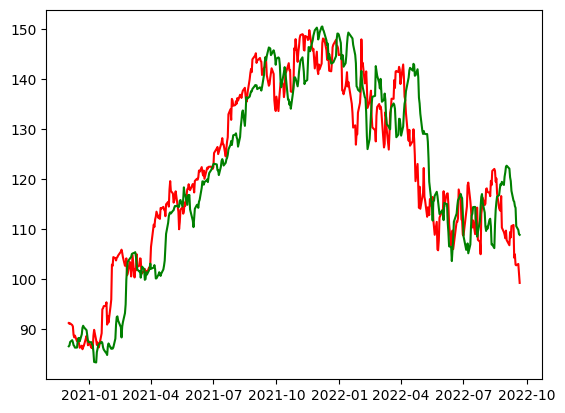

In [45]:
df_time = df.index[-len(y_test): ]
plt.plot(df_time, y_test, color='red', label='price')
plt.plot(df_time, pred, color='green', label='predict')
plt.show()

In [49]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/ (stored 0%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/keras_metadata.pb (deflated 92%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/fingerprint.pb (stored 0%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/saved_model.pb (deflated 91%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/assets/ (stored 0%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/variables/ (stored 0%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: content/models/GOOGL_8.45_03_mem_5_lstm_1_dense_1_unit_16/variables/variables.index (deflated 66%)
  adding: content/models/GOOGL_6.96_10_mem_5_lstm_2_dense_1_unit_8/ (stored 0%)
  adding: content/models/GOOGL_6.96_10_mem_5_lstm_2_dense_1_unit_8/keras_metadata.pb (deflated 9